# Regression Model

Since the target variable `target_xg` is continuous in the range [0, 1], the problem is a **regression task**.  
We begin with a **Linear Regression** model to establish a baseline, evaluating results with:

- **Mean Absolute Error (MAE)**  
- **Root Mean Squared Error (RMSE)**  
- **R² score**  

This baseline provides a first benchmark. It is possible also to try more advanced models – such as **Ridge, Lasso, and Tree-based regressors** – to improve predictive performance and better capture non-linear relationships in the data. 

## Dataset: DS0

### DS0 - Random Forest Regressor

In [6]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# Load dataset DS0
ds0 = pd.read_csv("../task1_xg/data/DS0.csv")

# Columns to drop (IDs and target)
columns_to_drop = [
    "event_id", "match_id", "team_id", 
    "player_id", "possession_team_id", "target_xg"
]

# Features (X) and Target (y)
X_ds0 = ds0.drop(columns=columns_to_drop)
y_ds0 = ds0["target_xg"]

print("Dataset DS0 loaded successfully")
print(f"Shape: {ds0.shape}")
print(f"Training Features: {X_ds0.shape[1]}")


Dataset DS0 loaded successfully
Shape: (88023, 47)
Training Features: 41


In [7]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    mean_absolute_error,
    make_scorer
)
from sklearn.ensemble import RandomForestRegressor

# Train/Test Split (80/20) for DS0
X_train_ds0, X_test_ds0, y_train_ds0, y_test_ds0 = train_test_split(
    X_ds0, y_ds0, test_size=0.2, random_state=42
)

print(f"Training set size DS0: {X_train_ds0.shape}, Test set size DS0: {X_test_ds0.shape}")

# Hyperparameter Grid for Random Forest
param_grid_ds0 = {
    "n_estimators": [300, 400, 500],
    "max_depth": [None, 30, 40, 50],
    "max_features": ["sqrt", "log2"]
}

# Define scorer (negative RMSE, since sklearn maximizes)
rmse_scorer_ds0 = make_scorer(
    lambda yt, yp: -np.sqrt(mean_squared_error(yt, yp))
)

# GridSearchCV with 5-fold cross-validation
grid_search_ds0 = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid=param_grid_ds0,
    cv=5,
    scoring=rmse_scorer_ds0,
    n_jobs=-1,
    verbose=1,
    refit=True
)

# Fit GridSearch
grid_search_ds0.fit(X_train_ds0, y_train_ds0)

print("Grid search completed for DS0")
print("Best Parameters:", grid_search_ds0.best_params_)


Training set size DS0: (70418, 41), Test set size DS0: (17605, 41)
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Grid search completed for DS0
Best Parameters: {'max_depth': 40, 'max_features': 'sqrt', 'n_estimators': 500}


In [8]:
# Complete results of cross-validation
df_results_ds0 = pd.DataFrame(grid_search_ds0.cv_results_)

# Show the most important columns
results_table_ds0 = df_results_ds0[[
    "param_n_estimators", "param_max_depth", "param_max_features",
    "mean_test_score", "std_test_score", "rank_test_score"
]].copy()

# Convert RMSE from negative to positive
results_table_ds0["mean_test_RMSE"] = -results_table_ds0["mean_test_score"]
results_table_ds0["std_test_RMSE"] = results_table_ds0["std_test_score"]

# Drop old columns and sort by rank
results_table_ds0 = results_table_ds0.drop(columns=["mean_test_score", "std_test_score"])
results_table_ds0 = results_table_ds0.sort_values("rank_test_score")

print("GridSearchCV results for DS0 (best combinations on top):")
display(results_table_ds0)

print("\nBest parameters from CV (DS0):")
print(grid_search_ds0.best_params_)
print(f"Best CV RMSE (DS0): {-grid_search_ds0.best_score_:.6f}")


GridSearchCV results for DS0 (best combinations on top):


,param_n_estimators,param_max_depth,param_max_features,rank_test_score,mean_test_RMSE,std_test_RMSE
14,500,40,sqrt,1,0.060695,0.001337
20,500,50,sqrt,2,0.060702,0.001359
2,500,None,sqrt,3,0.060702,0.001359
19,400,50,sqrt,4,0.060706,0.001343
1,400,None,sqrt,5,0.060708,0.001343
8,500,30,sqrt,6,0.060712,0.001399
13,400,40,sqrt,7,0.060713,0.001331
7,400,30,sqrt,8,0.060747,0.001396
18,300,50,sqrt,9,0.060754,0.001321
0,300,None,sqrt,10,0.060756,0.001321



Best parameters from CV (DS0):
{'max_depth': 40, 'max_features': 'sqrt', 'n_estimators': 500}
Best CV RMSE (DS0): 0.060695


In [9]:
# Test set Evaluation (DS0)
best_model_ds0 = grid_search_ds0.best_estimator_
y_pred_ds0 = best_model_ds0.predict(X_test_ds0)

# Metrics

# RMSE (Root Mean Squared Error)
# - Measures the average magnitude of the errors between predicted and actual values
# - Formula: RMSE = sqrt(mean_squared_error(y_true, y_pred))
# - The lower the RMSE, the better the model's performance
rmse_test = np.sqrt(mean_squared_error(y_test_ds0, y_pred_ds0))

# MAE (Mean Absolute Error)
# - Measures the average magnitude of the errors between predicted and actual values
# - Formula: MAE = mean_absolute_error(y_true, y_pred)
# - The lower the MAE, the better the model's performance
mae_test = mean_absolute_error(y_test_ds0, y_pred_ds0)

# R² (Coefficient of Determination)
# - Measures the proportion of the variance in the dependent variable that is predictable from the independent variables
# - Formula: R² = 1 - (SS_res / SS_tot)
#   where SS_res is the sum of squares of residuals and SS_tot is the total sum of squares
# - The higher the R², the better the model's performance
r2_test = r2_score(y_test_ds0, y_pred_ds0)

# Adjusted R² 
# - Adjusts R² to account for the number of predictors in the model
# - Formula: Adjusted R² = 1 - (1 - R²) * (n - 1) / (n - p - 1)
# - The higher the Adjusted R², the better the model's performance
n_ds0 = len(y_test_ds0)
p_ds0 = X_test_ds0.shape[1]
adjusted_r2_test = 1 - (1 - r2_test) * (n_ds0 - 1) / (n_ds0 - p_ds0 - 1)

# Create a DataFrame to display the metrics
metrics_df_ds0 = pd.DataFrame({
    "Metric": ["RMSE", "MAE", "R²", "Adjusted R²"],
    "Value": [rmse_test, mae_test, r2_test, adjusted_r2_test]
}).round(6)

print("Final Test Set Results (DS0):")
display(metrics_df_ds0)


Final Test Set Results (DS0):


,Metric,Value
0,RMSE,0.059724
1,MAE,0.029088
2,R²,0.843550
3,Adjusted R²,0.843185



 Feature Importance Ranking:
                     Feature  Importance
               angle_to_goal    0.203227
            distance_to_goal    0.167477
           shot_type_Penalty    0.102088
                       loc_x    0.090788
          play_pattern_Other    0.082958
                       loc_y    0.042584
         shot_type_Open_Play    0.033537
         shot_body_part_Head    0.029891
                  end_shot_x    0.029749
                  end_shot_y    0.029742
                      minute    0.026630
             shot_one_on_one    0.025443
                      second    0.019661
             shot_first_time    0.016816
              under_pressure    0.012530
   shot_body_part_Right_Foot    0.011367
       shot_technique_Normal    0.011007
    play_pattern_From_Corner    0.009545
                    period_5    0.009200
    shot_body_part_Left_Foot    0.007213
   play_pattern_From_Counter    0.004898
   play_pattern_Regular_Play    0.004132
 play_pattern_From_Free_Kic

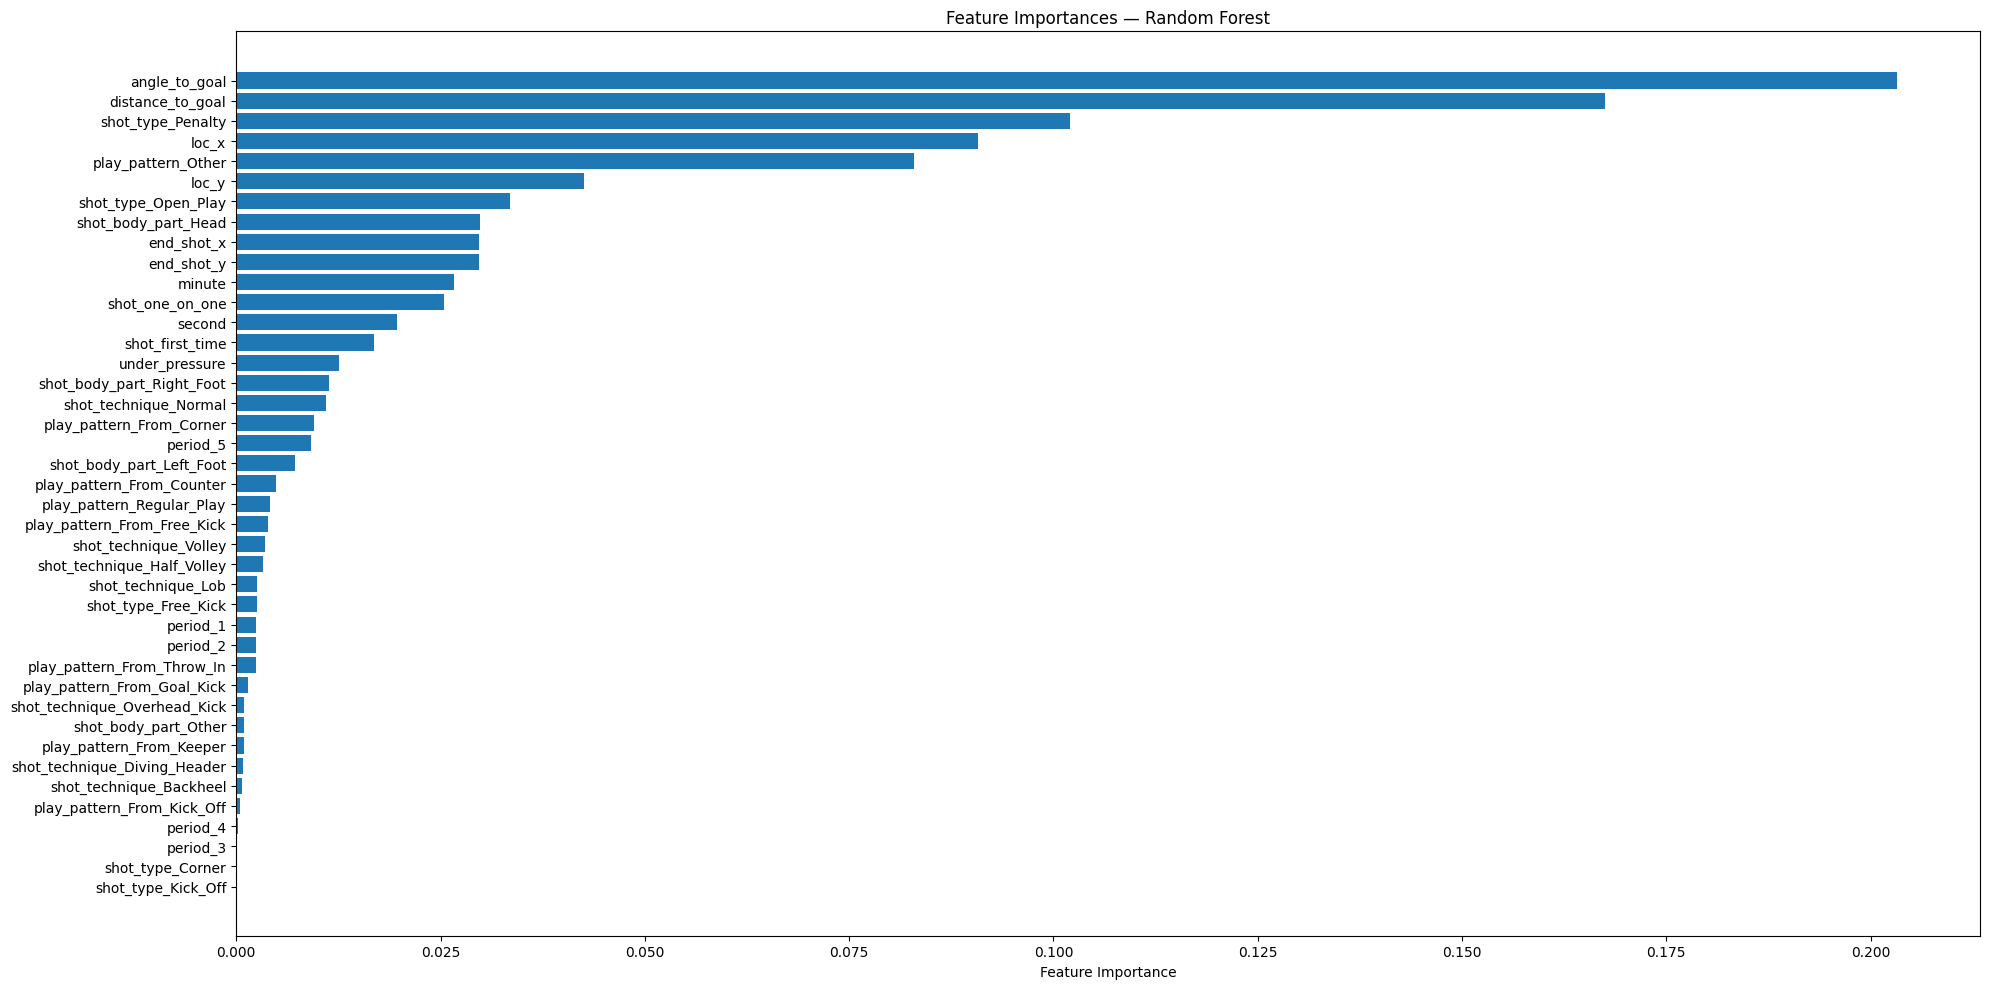

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Feature importances
importances = best_model_ds0.feature_importances_
features = X_ds0.columns
indices = np.argsort(importances)[::-1]

# Ranking
ranking = pd.DataFrame({
    "Feature": features[indices],
    "Importance": importances[indices]
})
print("\n Feature Importance Ranking:")
print(ranking.to_string(index=False))

# Plot of Feature Importances
plt.figure(figsize=(20, 10))
plt.barh(range(len(indices)), importances[indices][::-1], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices][::-1])
plt.xlabel("Feature Importance")
plt.title("Feature Importances — Random Forest")
plt.tight_layout()
plt.show()


## Dataset: DS1

### DS1 - Random Forest Regressor

In [11]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# Load dataset DS1
ds1 = pd.read_csv("../task1_xg/data/DS1.csv")

# Columns to drop (IDs and target)
columns_to_drop = [
    "event_id", "match_id", "team_id", 
    "player_id", "possession_team_id", "target_xg"
]

# Features (X) and Target (y)
X_ds1 = ds1.drop(columns=columns_to_drop)
y_ds1 = ds1["target_xg"]

print("Dataset DS1 loaded successfully")
print(f"Shape: {ds1.shape}")
print(f"Training Features: {X_ds1.shape[1]}")


Dataset DS1 loaded successfully
Shape: (88023, 48)
Training Features: 42


In [12]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    mean_absolute_error,
    make_scorer
)
from sklearn.ensemble import RandomForestRegressor

# Train/Test Split (80/20) for DS1
X_train_ds1, X_test_ds1, y_train_ds1, y_test_ds1 = train_test_split(
    X_ds1, y_ds1, test_size=0.2, random_state=42
)

print(f"Training set size DS1: {X_train_ds1.shape}, Test set size DS1: {X_test_ds1.shape}")

# Hyperparameter Grid for Random Forest
param_grid_ds1 = {
    "n_estimators": [300, 400, 500],
    "max_depth": [None, 30, 40, 50],
    "max_features": ["sqrt", "log2"]
}

# Define scorer (negative RMSE, since sklearn maximizes)
rmse_scorer_ds1 = make_scorer(
    lambda yt, yp: -np.sqrt(mean_squared_error(yt, yp))
)

# GridSearchCV with 5-fold cross-validation
grid_search_ds1 = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid=param_grid_ds1,
    cv=5,
    scoring=rmse_scorer_ds1,
    n_jobs=-1,
    verbose=1,
    refit=True
)

# Fit GridSearch
grid_search_ds1.fit(X_train_ds1, y_train_ds1)

print("Grid search completed for DS1")
print("Best Parameters:", grid_search_ds1.best_params_)


Training set size DS1: (70418, 42), Test set size DS1: (17605, 42)
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Grid search completed for DS1
Best Parameters: {'max_depth': 30, 'max_features': 'sqrt', 'n_estimators': 500}


In [13]:
# Complete results of cross-validation
df_results_ds1 = pd.DataFrame(grid_search_ds1.cv_results_)

# Show the most important columns
results_table_ds1 = df_results_ds1[[
    "param_n_estimators", "param_max_depth", "param_max_features",
    "mean_test_score", "std_test_score", "rank_test_score"
]].copy()

# Convert RMSE from negative to positive
results_table_ds1["mean_test_RMSE"] = -results_table_ds1["mean_test_score"]
results_table_ds1["std_test_RMSE"] = results_table_ds1["std_test_score"]

# Drop old columns and sort by rank
results_table_ds1 = results_table_ds1.drop(columns=["mean_test_score", "std_test_score"])
results_table_ds1 = results_table_ds1.sort_values("rank_test_score")

print("GridSearchCV results for DS1 (best combinations on top):")
display(results_table_ds1)

print("\nBest parameters from CV (DS1):")
print(grid_search_ds1.best_params_)
print(f"Best CV RMSE (DS1): {-grid_search_ds1.best_score_:.6f}")


GridSearchCV results for DS1 (best combinations on top):


,param_n_estimators,param_max_depth,param_max_features,rank_test_score,mean_test_RMSE,std_test_RMSE
8,500,30,sqrt,1,0.060377,0.001366
7,400,30,sqrt,2,0.060409,0.001352
2,500,None,sqrt,3,0.060415,0.001338
20,500,50,sqrt,4,0.060417,0.001342
14,500,40,sqrt,5,0.060427,0.001322
6,300,30,sqrt,6,0.060439,0.001319
1,400,None,sqrt,7,0.060448,0.001342
19,400,50,sqrt,8,0.060449,0.001345
13,400,40,sqrt,9,0.060460,0.001336
12,300,40,sqrt,10,0.060471,0.001315



Best parameters from CV (DS1):
{'max_depth': 30, 'max_features': 'sqrt', 'n_estimators': 500}
Best CV RMSE (DS1): 0.060377


In [14]:
# Test set Evaluation (DS1)
best_model_ds1 = grid_search_ds1.best_estimator_
y_pred_ds1 = best_model_ds1.predict(X_test_ds1)

# Metrics

# RMSE (Root Mean Squared Error)
# - Measures the average magnitude of the errors between predicted and actual values
# - Formula: RMSE = sqrt(mean_squared_error(y_true, y_pred))
# - The lower the RMSE, the better the model's performance
rmse_test = np.sqrt(mean_squared_error(y_test_ds1, y_pred_ds1))

# MAE (Mean Absolute Error)
# - Measures the average magnitude of the errors between predicted and actual values
# - Formula: MAE = mean_absolute_error(y_true, y_pred)
# - The lower the MAE, the better the model's performance
mae_test = mean_absolute_error(y_test_ds1, y_pred_ds1)

# R² (Coefficient of Determination)
# - Measures the proportion of the variance in the dependent variable that is predictable from the independent variables
# - Formula: R² = 1 - (SS_res / SS_tot)
#   where SS_res is the sum of squares of residuals and SS_tot is the total sum of squares
# - The higher the R², the better the model's performance
r2_test = r2_score(y_test_ds1, y_pred_ds1)

# Adjusted R² 
# - Adjusts R² to account for the number of predictors in the model
# - Formula: Adjusted R² = 1 - (1 - R²) * (n - 1) / (n - p - 1)
# - The higher the Adjusted R², the better the model's performance
n_ds1 = len(y_test_ds1)
p_ds1 = X_test_ds1.shape[1]
adjusted_r2_test = 1 - (1 - r2_test) * (n_ds1 - 1) / (n_ds1 - p_ds1 - 1)

# Create a DataFrame to display the metrics
metrics_df_ds1 = pd.DataFrame({
    "Metric": ["RMSE", "MAE", "R²", "Adjusted R²"],
    "Value": [rmse_test, mae_test, r2_test, adjusted_r2_test]
}).round(6)

print("Final Test Set Results (DS1):")
display(metrics_df_ds1)


Final Test Set Results (DS1):


,Metric,Value
0,RMSE,0.059530
1,MAE,0.028991
2,R²,0.844564
3,Adjusted R²,0.844193



 Feature Importance Ranking:
                     Feature  Importance
               angle_to_goal  0.19660467
            distance_to_goal  0.17159236
                       loc_x  0.09901342
           shot_type_Penalty  0.09322068
          play_pattern_Other  0.08403588
                       loc_y  0.04147763
         shot_body_part_Head  0.03197688
         shot_type_Open_Play  0.02983737
                  end_shot_y  0.02920783
                  end_shot_x  0.02853831
                      minute  0.02785088
             shot_one_on_one  0.02538051
                      second  0.01905288
             shot_first_time  0.01437589
              under_pressure  0.01383129
   shot_body_part_Right_Foot  0.01230598
                    period_5  0.01087572
       shot_technique_Normal  0.01086713
    play_pattern_From_Corner  0.00956171
    shot_body_part_Left_Foot  0.00716894
 play_pattern_From_Free_Kick  0.00501105
   play_pattern_From_Counter  0.00482478
   play_pattern_Regular_Pla

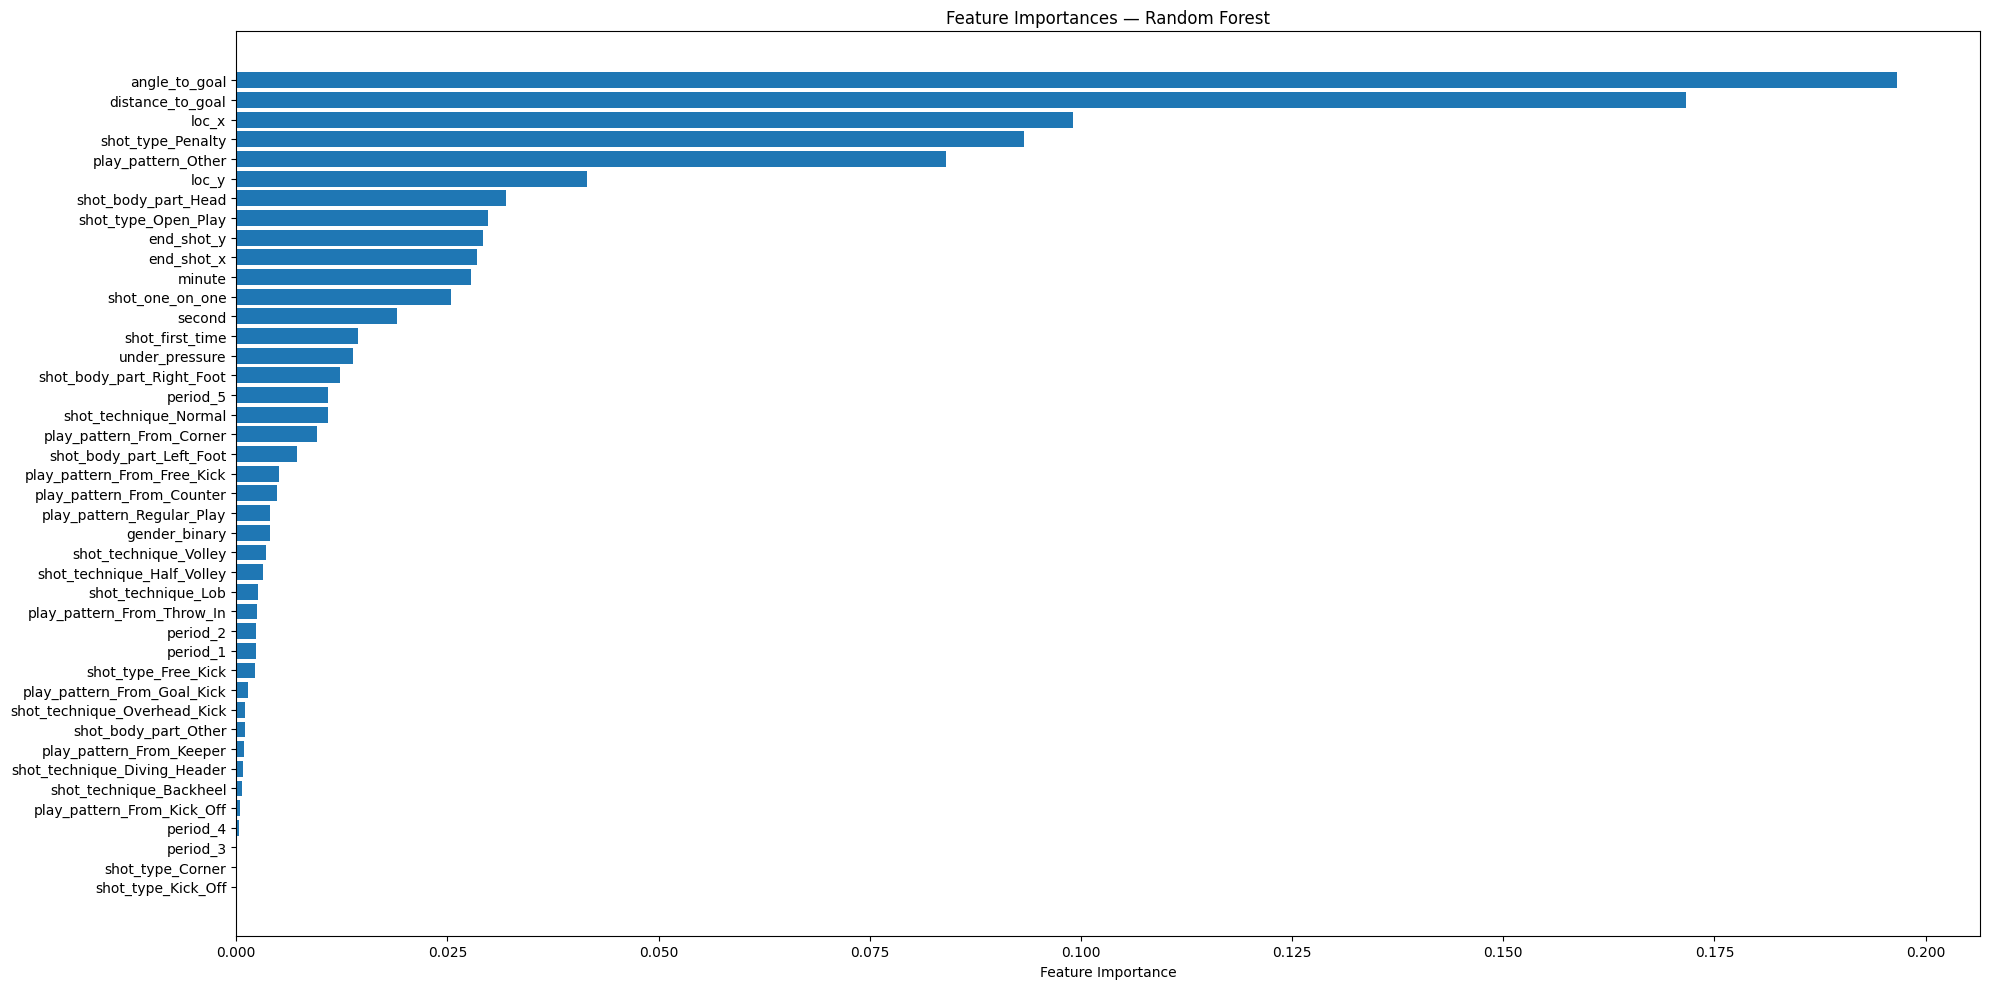

In [20]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Feature importances
importances = best_model_ds1.feature_importances_
features = X_ds1.columns
indices = np.argsort(importances)[::-1]

# Ranking
ranking = pd.DataFrame({
    "Feature": features[indices],
    "Importance": importances[indices]
})
pd.options.display.float_format = '{:.8f}'.format

print("\n Feature Importance Ranking:")
print(ranking.to_string(index=False))

# Plot of Feature Importances
plt.figure(figsize=(20, 10))
plt.barh(range(len(indices)), importances[indices][::-1], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices][::-1])
plt.xlabel("Feature Importance")
plt.title("Feature Importances — Random Forest")
plt.tight_layout()
plt.show()


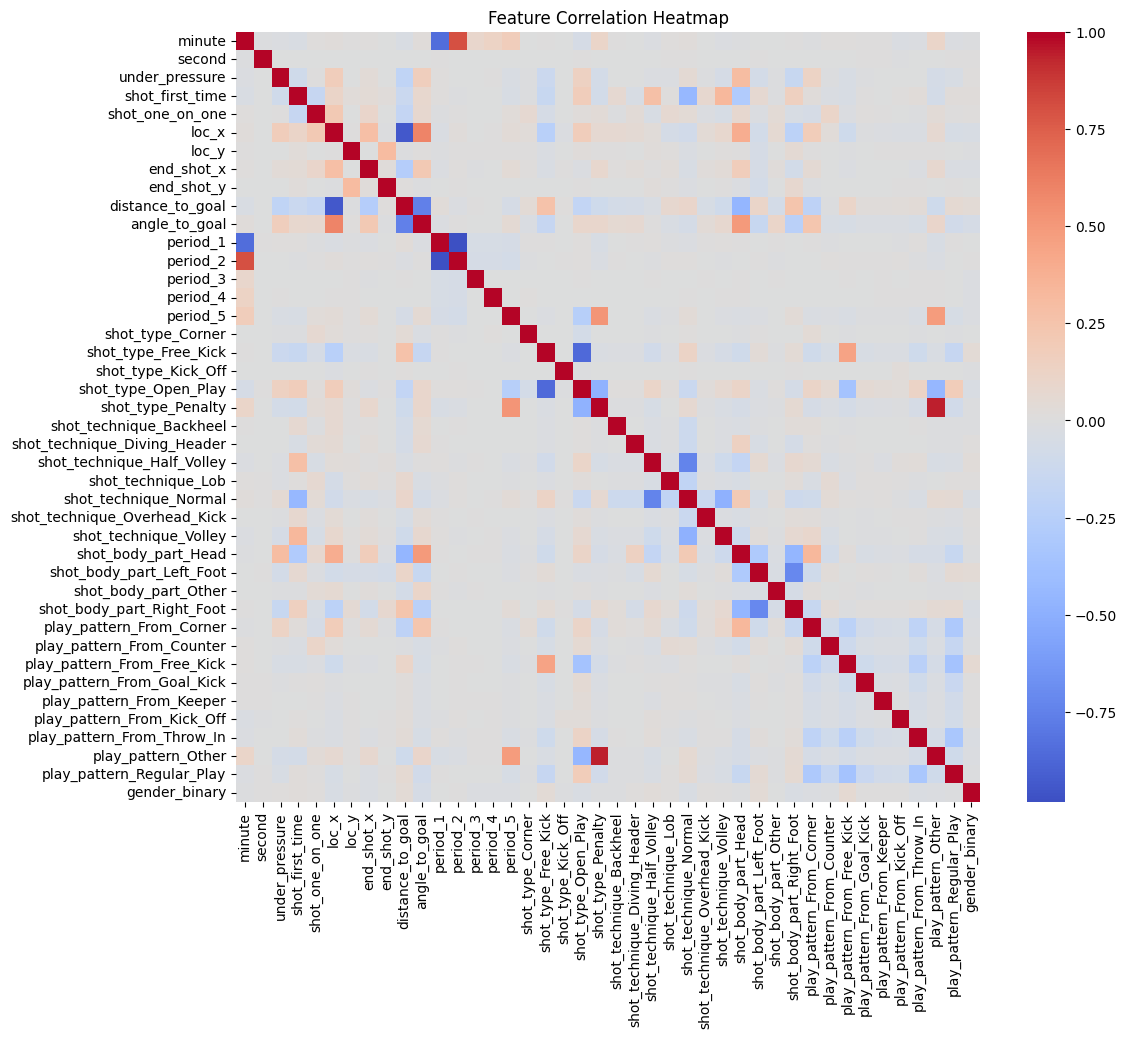

Strong correlations (>|0.25|):
play_pattern_Other          shot_type_Penalty             0.94349144
minute                      period_2                      0.80158078
angle_to_goal               loc_x                         0.59213922
shot_type_Penalty           period_5                      0.51349695
shot_body_part_Head         angle_to_goal                 0.49086186
period_5                    play_pattern_Other            0.48447998
shot_type_Free_Kick         play_pattern_From_Free_Kick   0.44292630
shot_body_part_Head         loc_x                         0.39150466
shot_technique_Volley       shot_first_time               0.33366921
shot_body_part_Head         play_pattern_From_Corner      0.32806232
end_shot_y                  loc_y                         0.30833072
under_pressure              shot_body_part_Head           0.29863433
loc_x                       end_shot_x                    0.28438964
shot_technique_Half_Volley  shot_first_time               0.27738369
dis

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming X is your DataFrame with the features
corr_matrix = X_ds1.corr()

# Correlation Heatmap 
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0, cbar=True)
plt.title("Feature Correlation Heatmap")
plt.show()

# Take absolute values of correlations
corr_pairs = (
    corr_matrix
    .unstack() # flatten matrix
    .sort_values(ascending=False) # sort from strongest to weakest
)

# Remove duplicates and diagonal
corr_pairs = corr_pairs[
    (corr_pairs < 1.0)  # drop self-correlation
].drop_duplicates()

# Print only strong correlations (threshold can be adjusted)
print("Strong correlations (>|0.25|):")
print(corr_pairs[corr_pairs > 0.25])
